# Posterior Estimation - MVN model ($D=2, n_{obs}=1$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from numpy.linalg import inv
from scipy.stats import multivariate_normal

from bayesflow.networks import InvertibleNetwork, FlattenNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
mu_0 = np.zeros(2)   # prior mean
sigma_0 = np.identity(2)   # prior covariance matrix
cov = np.array([[0.5,-0.35],[-0.35,1]])   # covariance matrix of likelihood


def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior distribution: mu ~ N(mu_0, sigma_0)
    p_samples = np.random.multivariate_normal(mu_0, sigma_0, batch_size)
    return p_samples.astype(np.float32)


def batch_simulator(prior_samples, n_obs):   # n_obs (number of observations in each dataset)
    """
    Simulate multiple MVN model datasets
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.empty((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations       
    
    for m in range(n_sim):
        mean = prior_samples[m]
        sim_data[m] = np.random.multivariate_normal(mean, cov, n_obs)
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 3,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [5]:
summary_net = FlattenNetwork()
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

We connect the prior and simulator through a *GenerativeModel* class which will take care of forward inference.

In [6]:
generative_model = GenerativeModel(prior, batch_simulator)

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True,
)

In [8]:
trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=generative_model,
    learning_rate = lr_schedule,
    checkpoint_path = './MVN1_3ACB_[32,32,32]_ckpts',
    max_to_keep=75,
    skip_checks=True
)

Networks loaded from ./MVN1_3ACB_[32,32,32]_ckpts\ckpt-75


### Online training

In [9]:
# Fixed n_obs
n_obs = 1

In [ ]:
%%time
losses = trainer.train_online(epochs=75, iterations_per_epoch=1000, batch_size=128, n_obs=n_obs)

epoch: 5, 10, 15, 20, 30, 40, 50, 75

loss: -0.006, -0.008, -0.013, -0.009, -0.014, -0.011, -0.009, -0.016

total epochs: 75 (results from epoch 20 on reasonably good), final loss: -0.016 (epoch 75)


correction constant: 0.016

KL loss: -0.016 + 0.016 = 0.000 (essentially 0)

## Computational faithfulness

In [10]:
param_prior = prior(1)   
x_data = batch_simulator(param_prior, n_obs)
n_post_samples = 7500 
param_samples = amortizer.sample(x_data, n_post_samples)   # BayesFlow samples from the learned posterior

In [11]:
# Empirical mean and covariance of learned posterior
print(np.mean(param_samples, axis = 0))
print(np.cov(param_samples.transpose()))

[ 0.04023208 -0.4483086 ]
[[ 0.31065675 -0.12090547]
 [-0.12090547  0.47459575]]


In [12]:
# Analytic posterior 
B = inv(sigma_0 + cov)
m = B @ x_data[0,0]
Lambda = B @ cov
posterior_xy = lambda x,y: multivariate_normal.pdf(np.array([x,y]), m, Lambda)

print(m)
print(Lambda)

[ 0.03784712 -0.44569381]
[[ 0.30495222 -0.12163336]
 [-0.12163336  0.47871416]]


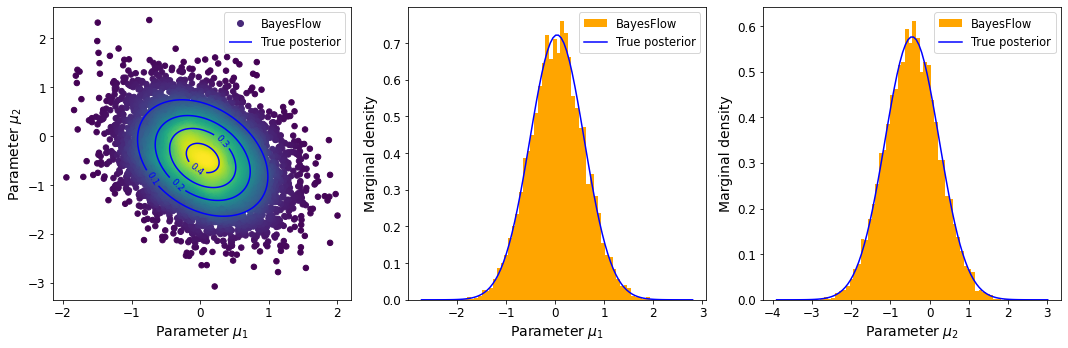

In [13]:
# Plot analytic vs. approximate posterior
plot_posterior(param_samples=param_samples, posterior_xy=posterior_xy, m=m, Lambda=Lambda, filename='MVN')

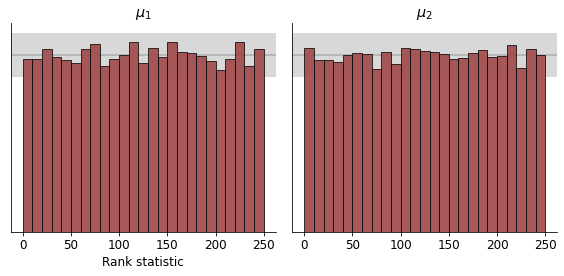

In [14]:
# Simulation-based calibration
n_sbc = 10000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_sbc = batch_simulator(params_sbc, n_obs)
param_samples = amortizer.sample(x_sbc, n_post_samples_sbc)
f = plot_sbc(param_samples, params_sbc, param_names=['$\mu_1$', '$\mu_2$'], filename='MVN')

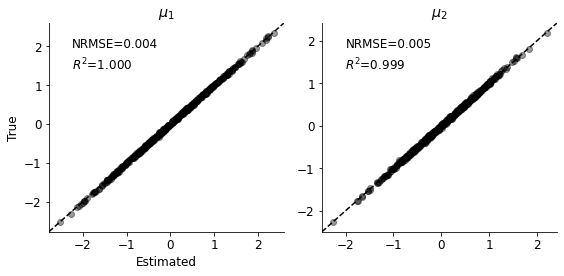

In [18]:
# Validation metrics
batch_size = 500
prior_params = prior(batch_size) 
x = batch_simulator(prior_params,n_obs).astype(np.float32)
param_samples = amortizer.sample(x, n_samples=1000) 
estimated_means = param_samples.mean(axis=1)
true_means = np.empty((batch_size, 2))
for k in range(batch_size):
    true_means[k] = B @ x[k,0]
f = true_vs_estimated(true_means, estimated_means, ['$\mu_1$', '$\mu_2$'], filename='MVN')